In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking


In [372]:
pre_df = pd.read_csv("/Users/maryellenfaulconer/Documents/NFL_Big_Data_Bowl/NFL-Big-Data-Bowl-2026/data/train/input_2023_w11.csv")
post_df = pd.read_csv("/Users/maryellenfaulconer/Documents/NFL_Big_Data_Bowl/NFL-Big-Data-Bowl-2026/data/train/output_2023_w11.csv")

df_combined = pre_df.merge(
    post_df,
    on=["game_id", "play_id", "nfl_id"],
    suffixes=("_pre", "_post")
)

df_combined = df_combined[df_combined['play_id'] == 56]
df_combined = df_combined[df_combined['player_name'] == 'Akeem Davis-Gaither']

df_combined.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id_pre,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,frame_id_post,x_post,y_post
0,2023111600,56,True,52515,1,right,35,Akeem Davis-Gaither,6-2,215,...,0.02,0.01,78.54,256.24,14,43.639999,7.7,1,40.63,15.80
1,2023111600,56,True,52515,1,right,35,Akeem Davis-Gaither,6-2,215,...,0.02,0.01,78.54,256.24,14,43.639999,7.7,2,40.92,15.39
2,2023111600,56,True,52515,1,right,35,Akeem Davis-Gaither,6-2,215,...,0.02,0.01,78.54,256.24,14,43.639999,7.7,3,41.17,14.98
3,2023111600,56,True,52515,1,right,35,Akeem Davis-Gaither,6-2,215,...,0.02,0.01,78.54,256.24,14,43.639999,7.7,4,41.41,14.56
4,2023111600,56,True,52515,1,right,35,Akeem Davis-Gaither,6-2,215,...,0.02,0.01,78.54,256.24,14,43.639999,7.7,5,41.63,14.11


In [373]:
#  make new column in df that sums num_frames_output and frame_id_post

agg_frames = (
    df_combined
    .groupby(["play_id", "nfl_id"], as_index=False)
    .agg(
        max_frame_id_pre=("frame_id_pre", "max")
    )
)


frames = df_combined.merge(
    agg_frames,
    on=["play_id", "nfl_id"]
)

frames = frames.rename(columns={"num_id_post": "frame_id_post"})
frames["frame_id_post"] = frames["max_frame_id_pre"] + frames["frame_id_post"]

frames.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id_pre,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,a,dir,o,num_frames_output,ball_land_x,ball_land_y,frame_id_post,x_post,y_post,max_frame_id_pre
0,2023111600,56,True,52515,1,right,35,Akeem Davis-Gaither,6-2,215,...,0.01,78.54,256.24,14,43.639999,7.7,32,40.63,15.80,31
1,2023111600,56,True,52515,1,right,35,Akeem Davis-Gaither,6-2,215,...,0.01,78.54,256.24,14,43.639999,7.7,33,40.92,15.39,31
2,2023111600,56,True,52515,1,right,35,Akeem Davis-Gaither,6-2,215,...,0.01,78.54,256.24,14,43.639999,7.7,34,41.17,14.98,31
3,2023111600,56,True,52515,1,right,35,Akeem Davis-Gaither,6-2,215,...,0.01,78.54,256.24,14,43.639999,7.7,35,41.41,14.56,31
4,2023111600,56,True,52515,1,right,35,Akeem Davis-Gaither,6-2,215,...,0.01,78.54,256.24,14,43.639999,7.7,36,41.63,14.11,31


In [374]:
# # isolating 1 player to test frame_id merging logic
# GAME_ID_TEST = 2023111600 # Assuming this is the game ID for play 55 based on file name
# PLAY_ID_TEST = 56
# PLAYER_NAME_TEST = 52515  # Akeem Davis-Gaither's NFL ID

# pre_df = pre_df[
#     (pre_df['play_id'] == PLAY_ID_TEST) & 
#     (pre_df['nfl_id'] == PLAYER_NAME_TEST) &
#     (pre_df['game_id'] == GAME_ID_TEST)
# ].copy()

# post_df = post_df[
#     (post_df['play_id'] == PLAY_ID_TEST) & 
#     (post_df['nfl_id'] == PLAYER_NAME_TEST) &
#     (post_df['game_id'] == GAME_ID_TEST)
# ].copy()

# # Confirm we have the right counts before merge
# print(f"Rows in pre_df (filtered): {len(pre_df)}")
# print(f"Rows in post_df (filtered): {len(post_df)}")

# # 2. Calculate the offset and apply it to the POST data

# # We only need the max frame_id for THIS specific filtered set now
# frame_offset = pre_df['frame_id'].max()

# # Add the offset to the post_df's frame_id to create an absolute frame ID
# # The first frame in post_df starts at 1, so offset + current_frame_id works
# post_df['frame_id'] = frame_offset + post_df['frame_id']

# # Rename the column in both dataframes to match your desired output name before stacking
# pre_df = pre_df.rename(columns={"frame_id": "frame_id_total"})
# post_df = post_df.rename(columns={"frame_id": "frame_id_total"})

# # 3. Combine vertically
# df_combined_total = pd.concat([pre_df, post_df], ignore_index=True)

# print(f"Total combined rows for Akeem Davis-Gaither (Play 56): {len(df_combined_total)}")

In [375]:
# ## function to go through entire dataframe and create new dataframe with start and end frames for each play_id and nfl_id
# pre_df = pd.read_csv("/Users/maryellenfaulconer/Documents/NFL_Big_Data_Bowl/NFL-Big-Data-Bowl-2026/data/train/input_2023_w11.csv")
# post_df = pd.read_csv("/Users/maryellenfaulconer/Documents/NFL_Big_Data_Bowl/NFL-Big-Data-Bowl-2026/data/train/output_2023_w11.csv")


# # Filter for just one play to test all players on that play.. just for testing the function
# GAME_ID_TEST = 2023111600
# PLAY_ID_TEST = 56

# pre_play_df = pre_df[(pre_df['game_id'] == GAME_ID_TEST) & (pre_df['play_id'] == PLAY_ID_TEST)].copy()
# post_play_df = post_df[(post_df['game_id'] == GAME_ID_TEST) & (post_df['play_id'] == PLAY_ID_TEST)].copy()


# # 1. Calculate the offset for *each player* within the test play
# offset_df = pre_play_df.groupby(["game_id", "play_id", "nfl_id"])["frame_id"].max().reset_index()
# offset_df = offset_df.rename(columns={"frame_id": "frame_id_offset"})

# # 2. Add the offset to the POST data and calculate total ID
# post_play_df = post_play_df.merge(offset_df, on=["game_id", "play_id", "nfl_id"], how="left")
# post_play_df["frame_id_total"] = post_play_df["frame_id_offset"] + post_play_df["frame_id"]

# # 3. Prepare both dataframes for concatenation
# pre_play_df = pre_play_df.rename(columns={"frame_id": "frame_id_total"})
# pre_play_df = pre_play_df.drop(columns=['num_frames_output'], errors='ignore') # Drop pre-data specific columns if needed
# post_play_df = post_play_df.drop(columns=["frame_id_offset", "frame_id"], errors='ignore') # Drop temporary and original frame_id

# # 4. Concatenate vertically
# df_combined_total = pd.concat([pre_play_df, post_play_df], ignore_index=True)

# df_combined_total

In [376]:
# # --- 0. Filter to test player ---
# GAME_ID_TEST = 2023111600
# PLAY_ID_TEST = 56
# PLAYER_ID_TEST = 52515  # nfl_id

# pre_df = pre_df[
#     (pre_df['game_id'] == GAME_ID_TEST) &
#     (pre_df['play_id'] == PLAY_ID_TEST) &
#     (pre_df['nfl_id'] == PLAYER_ID_TEST)
# ].copy()

# post_df = post_df[
#     (post_df['game_id'] == GAME_ID_TEST) &
#     (post_df['play_id'] == PLAY_ID_TEST) &
#     (post_df['nfl_id'] == PLAYER_ID_TEST)
# ].copy()

# --- 1. Compute max pre-pass frame for player ---
offset_df = (
    pre_df.groupby(["game_id", "play_id", "nfl_id"], sort=False)["frame_id"]
          .max()
          .rename("frame_id_offset")
          .reset_index()
)

# --- 2. Merge offsets into post ---
post_df = post_df.merge(offset_df, on=["game_id", "play_id", "nfl_id"], how="left")

# --- 3. Compute total frame_id for post-pass ---
post_df["frame_id_total"] = post_df["frame_id"] + post_df["frame_id_offset"]

# --- 4. Prepare pre-pass dataframe ---
pre_df = pre_df.rename(columns={"frame_id": "frame_id_total"})
pre_df = pre_df.drop(columns=["num_frames_output"], errors="ignore")

# --- 5. Drop temporary columns from post_df ---
post_df = post_df.drop(columns=["frame_id_offset", "frame_id"], errors="ignore")

# --- 6. Concatenate pre + post frames ---
full_df = pd.concat([pre_df, post_df], ignore_index=True)

# --- 7. Sort by game/play/player/frame ---
full_df.sort_values(
    ["game_id", "play_id", "nfl_id", "frame_id_total"],
    inplace=True,
    kind="mergesort"
)

# --- 8. Forward-fill static player/play info (not motion variables) ---
fill_cols = [
    "player_name", "player_height", "player_weight", "player_birth_date",
    "player_position", "player_side", "player_role", "player_to_predict",
    "absolute_yardline_number", "play_direction", "num_frames_output",
    "ball_land_x", "ball_land_y"
]
fill_cols_existing = [c for c in fill_cols if c in full_df.columns]

full_df[fill_cols_existing] = (
    full_df.groupby(["game_id", "play_id", "nfl_id"])[fill_cols_existing]
           .ffill()
           .bfill()  # ensure first frame also filled
)
full_df



/var/folders/nx/y262pp8d4dzf82b2kl0f_g340000gn/T/ipykernel_12301/2128143262.py:61: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .bfill()  # ensure first frame also filled


,game_id,play_id,player_to_predict,nfl_id,frame_id_total,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_side,player_role,x,y,s,a,dir,o,ball_land_x,ball_land_y
310,2023111600,56,False,46101,1,right,35.0,Lamar Jackson,6-2,212.0,...,Offense,Passer,29.58,23.84,0.00,0.00,288.62,86.22,43.639999,7.7
311,2023111600,56,False,46101,2,right,35.0,Lamar Jackson,6-2,212.0,...,Offense,Passer,29.58,23.84,0.00,0.00,289.20,86.22,43.639999,7.7
312,2023111600,56,False,46101,3,right,35.0,Lamar Jackson,6-2,212.0,...,Offense,Passer,29.58,23.83,0.00,0.00,285.18,86.22,43.639999,7.7
313,2023111600,56,False,46101,4,right,35.0,Lamar Jackson,6-2,212.0,...,Offense,Passer,29.57,23.83,0.00,0.00,283.23,86.22,43.639999,7.7
314,2023111600,56,False,46101,5,right,35.0,Lamar Jackson,6-2,212.0,...,Offense,Passer,29.57,23.83,0.00,0.00,283.18,85.42,43.639999,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242935,2023112000,4207,False,56242,39,left,76.0,Eli Ricks,6-2,195.0,...,Defense,Defensive Coverage,52.72,9.68,3.12,3.58,272.00,36.09,47.660000,38.5
242936,2023112000,4207,False,56242,40,left,76.0,Eli Ricks,6-2,195.0,...,Defense,Defensive Coverage,52.41,9.71,3.22,3.33,279.30,30.25,47.660000,38.5
242937,2023112000,4207,False,56242,41,left,76.0,Eli Ricks,6-2,195.0,...,Defense,Defensive Coverage,52.08,9.79,3.38,3.44,287.70,29.43,47.660000,38.5
242938,2023112000,4207,False,56242,42,left,76.0,Eli Ricks,6-2,195.0,...,Defense,Defensive Coverage,51.76,9.92,3.51,3.14,293.67,27.46,47.660000,38.5


In [377]:
# Show a few rows
print(full_df[["frame_id_total"]].head(10))

# dtypes
print(full_df[["frame_id_total"]].dtypes)

# unique counts / values
print("frame_id_total unique:", full_df["frame_id_total"].nunique())



     frame_id_total
310               1
311               2
312               3
313               4
314               5
315               6
316               7
317               8
318               9
319              10
frame_id_total    int64
dtype: object
frame_id_total unique: 98


In [378]:
# --- 9. Compute base motion features ---
df = full_df.sort_values(["nfl_id", "game_id", "play_id", "frame_id_total"])

dir_rad = np.deg2rad(df["dir"].to_numpy())
df["vx"] = df["s"].to_numpy() * np.cos(dir_rad)
df["vy"] = df["s"].to_numpy() * np.sin(dir_rad)
df["ax"] = df["a"].to_numpy() * np.cos(dir_rad)
df["ay"] = df["a"].to_numpy() * np.sin(dir_rad)
df["dir_rad"] = dir_rad

# --- 10. Add lag and lead features ---
group_cols = ["game_id", "play_id", "nfl_id"]
gb = df.groupby(group_cols, group_keys=False)

# --- Lag features commented out for NN ---
# lag_features = ["x", "y", "vx", "vy", "ax", "ay"]
# for lag in [1, 2]:
#     shifted = gb[lag_features].shift(lag)
#     shifted.columns = [f"{c}_lag{lag}" for c in shifted.columns]
#     df = pd.concat([df, shifted], axis=1)

# Lead (target) features — NEXT FRAME
lead = gb[["x", "y"]].shift(-1)
lead.columns = ["x_next", "y_next"]
df = pd.concat([df, lead], axis=1)

# Remove rows without next-frame targets
df = df.dropna(subset=["x_next", "y_next"]).reset_index(drop=True)

df

,game_id,play_id,player_to_predict,nfl_id,frame_id_total,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,o,ball_land_x,ball_land_y,vx,vy,ax,ay,dir_rad,x_next,y_next
0,2023111902,152,False,30842,1,left,53.0,Marcedes Lewis,6-6,267.0,...,291.99,49.119999,38.07,0.136349,-0.146318,0.395411,-0.424323,5.462531,54.21,31.98
1,2023111902,152,False,30842,2,left,53.0,Marcedes Lewis,6-6,267.0,...,291.39,49.119999,38.07,0.149476,-0.200392,0.346785,-0.464909,5.353274,54.18,31.99
2,2023111902,152,False,30842,3,left,53.0,Marcedes Lewis,6-6,267.0,...,292.08,49.119999,38.07,0.114000,-0.299005,0.252937,-0.663418,5.076639,54.12,32.00
3,2023111902,152,False,30842,4,left,53.0,Marcedes Lewis,6-6,267.0,...,290.49,49.119999,38.07,0.068441,-0.555802,0.160103,-1.300180,4.834911,54.04,32.00
4,2023111902,152,False,30842,5,left,53.0,Marcedes Lewis,6-6,267.0,...,294.21,49.119999,38.07,-0.058493,-0.858008,-0.157795,-2.314628,4.644321,53.94,31.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262319,2023111905,3038,False,56673,19,right,77.0,Eric Garror,5-9,178.0,...,231.43,83.559998,23.74,-2.990087,2.863386,-1.950057,1.867426,2.377837,84.47,13.54
262320,2023111905,3038,False,56673,20,right,77.0,Eric Garror,5-9,178.0,...,238.25,83.559998,23.74,-2.520251,3.002454,-2.211649,2.634807,2.269103,84.78,13.30
262321,2023111905,3038,False,56673,21,right,77.0,Eric Garror,5-9,178.0,...,243.44,83.559998,23.74,-2.109519,3.039726,-2.143727,3.089018,2.177473,85.08,13.12
262322,2023111905,3038,False,56673,22,right,77.0,Eric Garror,5-9,178.0,...,254.17,83.559998,23.74,-1.679961,3.013342,-1.918564,3.441324,2.079385,85.37,12.98


In [379]:

# --- 11. Convert categoricals ---
cat_cols = ["player_role", "player_position", "play_direction"]
for col in cat_cols:
    df[col] = df[col].astype("category")

# --- 12. Subset to players to predict ---
to_predict = df.loc[df["player_to_predict"]].copy()

# --- 13. Optional: One-hot encoding for model input ---
# Play direction (left/right)
play_dir_categories = to_predict["play_direction"].cat.categories
if "right" in play_dir_categories:
    right_idx = play_dir_categories.get_loc("right")
    to_predict["play_direction_num"] = (
        to_predict["play_direction"].cat.codes == right_idx
    ).astype(int)
# else: could default to 0 if "right" not present

# #Optional numeric encoding for positions/roles (skip if using embeddings)
to_predict["player_position_WR"] = (to_predict["player_position"] == "WR").astype(int)
to_predict["player_position_RB"] = (to_predict["player_position"] == "RB").astype(int)
to_predict["player_position_QB"] = (to_predict["player_position"] == "QB").astype(int)
to_predict["player_role_Targeted"] = (to_predict["player_role"] == "Targeted Receiver").astype(int)
to_predict["player_role_Passer"] = (to_predict["player_role"] == "Passer").astype(int)
to_predict["player_role_Def"] = (to_predict["player_role"] == "Defensive Coverage").astype(int)


to_predict

,game_id,play_id,player_to_predict,nfl_id,frame_id_total,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,dir_rad,x_next,y_next,play_direction_num,player_position_WR,player_position_RB,player_position_QB,player_role_Targeted,player_role_Passer,player_role_Def
120,2023111902,2894,True,30842,1,left,53.0,Marcedes Lewis,6-6,267.0,...,5.177170,54.47,23.62,0,0,0,0,1,0,0
121,2023111902,2894,True,30842,2,left,53.0,Marcedes Lewis,6-6,267.0,...,5.285206,54.44,23.64,0,0,0,0,1,0,0
122,2023111902,2894,True,30842,3,left,53.0,Marcedes Lewis,6-6,267.0,...,5.509306,54.39,23.70,0,0,0,0,1,0,0
123,2023111902,2894,True,30842,4,left,53.0,Marcedes Lewis,6-6,267.0,...,5.551194,54.30,23.80,0,0,0,0,1,0,0
124,2023111902,2894,True,30842,5,left,53.0,Marcedes Lewis,6-6,267.0,...,5.537755,54.17,23.94,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262162,2023111905,1822,True,56673,39,left,24.0,Eric Garror,5-9,178.0,...,NaN,10.23,47.70,0,0,0,0,0,0,1
262163,2023111905,1822,True,56673,40,left,24.0,Eric Garror,5-9,178.0,...,NaN,10.06,48.39,0,0,0,0,0,0,1
262164,2023111905,1822,True,56673,41,left,24.0,Eric Garror,5-9,178.0,...,NaN,9.90,49.07,0,0,0,0,0,0,1
262165,2023111905,1822,True,56673,42,left,24.0,Eric Garror,5-9,178.0,...,NaN,9.73,49.73,0,0,0,0,0,0,1


In [380]:
# --- Drop rows with missing lag features (optional) ---
# For NN, we often don't need lag features explicitly, 
# so this step can be skipped or commented out.

# lag_cols = [col for col in to_predict.columns if "lag" in col]
# to_predict = to_predict.dropna(subset=lag_cols)


In [382]:
# --- 12a. Subset to single game for testing ---
GAME_ID_TEST = 2023111600
to_predict_game = to_predict[to_predict["game_id"] == GAME_ID_TEST].copy()

# --- Sort by player/play/frame to ensure proper sequences ---
to_predict_game = to_predict_game.sort_values(
    ["game_id", "play_id", "nfl_id", "frame_id_total"]
)

# --- 14. Feature and target columns ---
feature_cols = [
    "x", "y", "vx", "vy", "ax", "ay",       # motion features
    "o", "dir",                              # orientation
    "play_direction_num",                    # categorical encoded
    "player_position_WR", "player_position_RB", "player_position_QB",  # positions
    "player_role_Targeted", "player_role_Passer", "player_role_Def",  # roles
    "ball_land_x", "ball_land_y"             # ball landing info
]
target_cols = ["x_next", "y_next"]

# --- 16. Helper function to create sequences ---
def create_sequences(df, seq_len, feature_cols, target_cols):
    sequences_X = []
    sequences_y = []
    
    for (game_id, play_id, nfl_id), group in df.groupby(["game_id", "play_id", "nfl_id"]):
        if len(group) >= seq_len:  # only take full sequences
            # Last seq_len frames before ball is thrown
            seq_X = group[feature_cols].values[-seq_len:]
            seq_y = group[target_cols].values[-1]  # next-frame target
            sequences_X.append(seq_X)
            sequences_y.append(seq_y)
    
    return np.array(sequences_X), np.array(sequences_y)

# --- 16a. Create sequences for LSTM ---
SEQ_LEN = 96  # number of pre-ball frames
X_seq, y_seq = create_sequences(to_predict_game, SEQ_LEN, feature_cols, target_cols)

# --- 17. Split sequences into train/val ---
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(np.arange(len(X_seq)), test_size=0.2, random_state=42)
X_train, y_train = X_seq[train_idx], y_seq[train_idx]
X_val, y_val = X_seq[val_idx], y_seq[val_idx]

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)



ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# --- 18. Standardize numeric features across sequences ---
n_samples, seq_len, n_features = X_train.shape
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, n_features)
X_train_flat = scaler.fit_transform(X_train_flat)
X_train = X_train_flat.reshape(n_samples, seq_len, n_features)

X_val_flat = X_val.reshape(-1, n_features)
X_val = scaler.transform(X_val_flat).reshape(X_val.shape)


In [ ]:
# # test on one game for now
# GAME_ID_TEST = 2023111600
# game_df = full_df[full_df["game_id"] == GAME_ID_TEST].copy()

# plays = to_predict[["play_id"]].drop_duplicates()
# train_plays, val_plays = train_test_split(plays, test_size=0.2, random_state=42)

# # Add play_id to features and targets for masking
# X = to_predict[feature_cols].copy()
# X["play_id"] = to_predict["play_id"]
# y = to_predict[targets].copy()
# y["play_id"] = to_predict["play_id"]

# # Masks
# train_mask = X["play_id"].isin(train_plays["play_id"])
# val_mask = X["play_id"].isin(val_plays["play_id"])

# # Split and drop temporary play_id
# X_train = X[train_mask].drop(columns=["play_id"])
# y_train = y[train_mask].drop(columns=["play_id"])
# X_val = X[val_mask].drop(columns=["play_id"])
# y_val = y[val_mask].drop(columns=["play_id"])

# # --- 8. Standardize numeric features ---
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

# print("Train shape:", X_train.shape, y_train.shape)
# print("Validation shape:", X_val.shape, y_val.shape)



Train shape: (70503, 17) (70503, 2)
Validation shape: (19590, 17) (19590, 2)


In [368]:
# --- 20. Define sequence length (all pre-pass frames) ---
# We'll group by player/play and take all frames before the target (x_next, y_next)
group_cols = ["game_id", "play_id", "nfl_id"]

# --- 21. Sort to ensure temporal order ---
to_predict = to_predict.sort_values(group_cols + ["frame_id_total"])

# --- 22. Collect sequences per player/play ---
sequence_features = feature_cols  # all features for the model

player_sequences = []
target_sequences = []

for _, player_df in to_predict.groupby(group_cols):
    # Features: all rows except the last (because last row's target is next frame)
    X_seq = player_df[sequence_features].iloc[:-1].values
    # Targets: x_next, y_next (shifted by -1)
    y_seq = player_df[target_cols].iloc[1:].values

    # Ensure sequence length > 0
    if len(X_seq) > 0:
        player_sequences.append(X_seq)
        target_sequences.append(y_seq)

# --- 23. Pad sequences to same length if needed (for batch training) ---
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Find max sequence length
max_len = max(seq.shape[0] for seq in player_sequences)

# Pad sequences with zeros (or use masking in your model)
X_padded = pad_sequences(player_sequences, maxlen=max_len, dtype='float32', padding='pre', value=0.0)
y_padded = pad_sequences(target_sequences, maxlen=max_len, dtype='float32', padding='pre', value=0.0)

print("Padded X shape:", X_padded.shape)  # (num_players, seq_len, num_features)
print("Padded y shape:", y_padded.shape)  # (num_players, seq_len, 2)


Padded X shape: (2298, 96, 17)
Padded y shape: (2298, 96, 2)


In [369]:
## Build neural network model
model = Sequential([
    LSTM(128, activation="tanh", input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(2, activation="linear")  # outputs: x_next, y_next
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",
    metrics=["RootMeanSquaredError"]
)

IndexError: tuple index out of range

In [340]:
## train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=1
)


Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 17), dtype=float32). Expected shape (None, 96, 17), but input has incompatible shape (None, 17)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 17), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

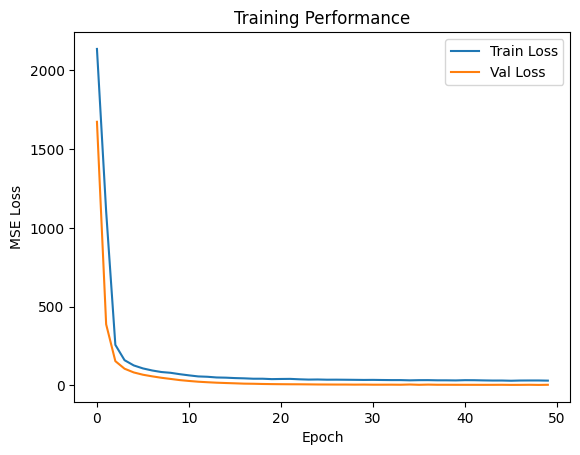

Validation MSE: 3.243 yards


In [22]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Performance")
plt.show()

# Numeric evaluation
loss, mse = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation MSE: {mse:.3f} yards")

In [21]:
train_mse = history.history['loss']
val_mse = history.history['val_loss']

In [23]:
print(min(val_mse))
print(max(val_mse))

2.3536291122436523
1673.9202880859375


In [15]:
## predict on validation set
y_pred = model.predict(X_val)
pred_df = pd.DataFrame(y_pred, columns=["x_pred", "y_pred"])
pred_df.head()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


,x_pred,y_pred
0,53.738251,12.563228
1,24.186693,20.633192
2,44.853794,36.316620
3,89.815392,18.778351
4,38.808712,20.494888
